In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("./data/diagnosis.data", encoding="utf-16", header=None, delimiter="\t")
df[0] = df[0].str.replace(',', '.').astype(float)
df.columns = ['temperature', 'nausea', 'lumbar-pain', 'urine-pushing', 'micturition-pains', 'burning-urethra', 'bladder-inflammation', 'nephritis']
df = df.replace({'yes': 1, 'no': 0})
df

,temperature,nausea,lumbar-pain,urine-pushing,micturition-pains,burning-urethra,bladder-inflammation,nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


In [4]:
#split the df into train and test
X = df.drop(columns=['bladder-inflammation', 'nephritis'])
y = df[['bladder-inflammation', 'nephritis']]

In [5]:
#using the tree classifier
tree = DecisionTreeClassifier(random_state=45)
tree.fit(X, y)

DecisionTreeClassifier(random_state=45)

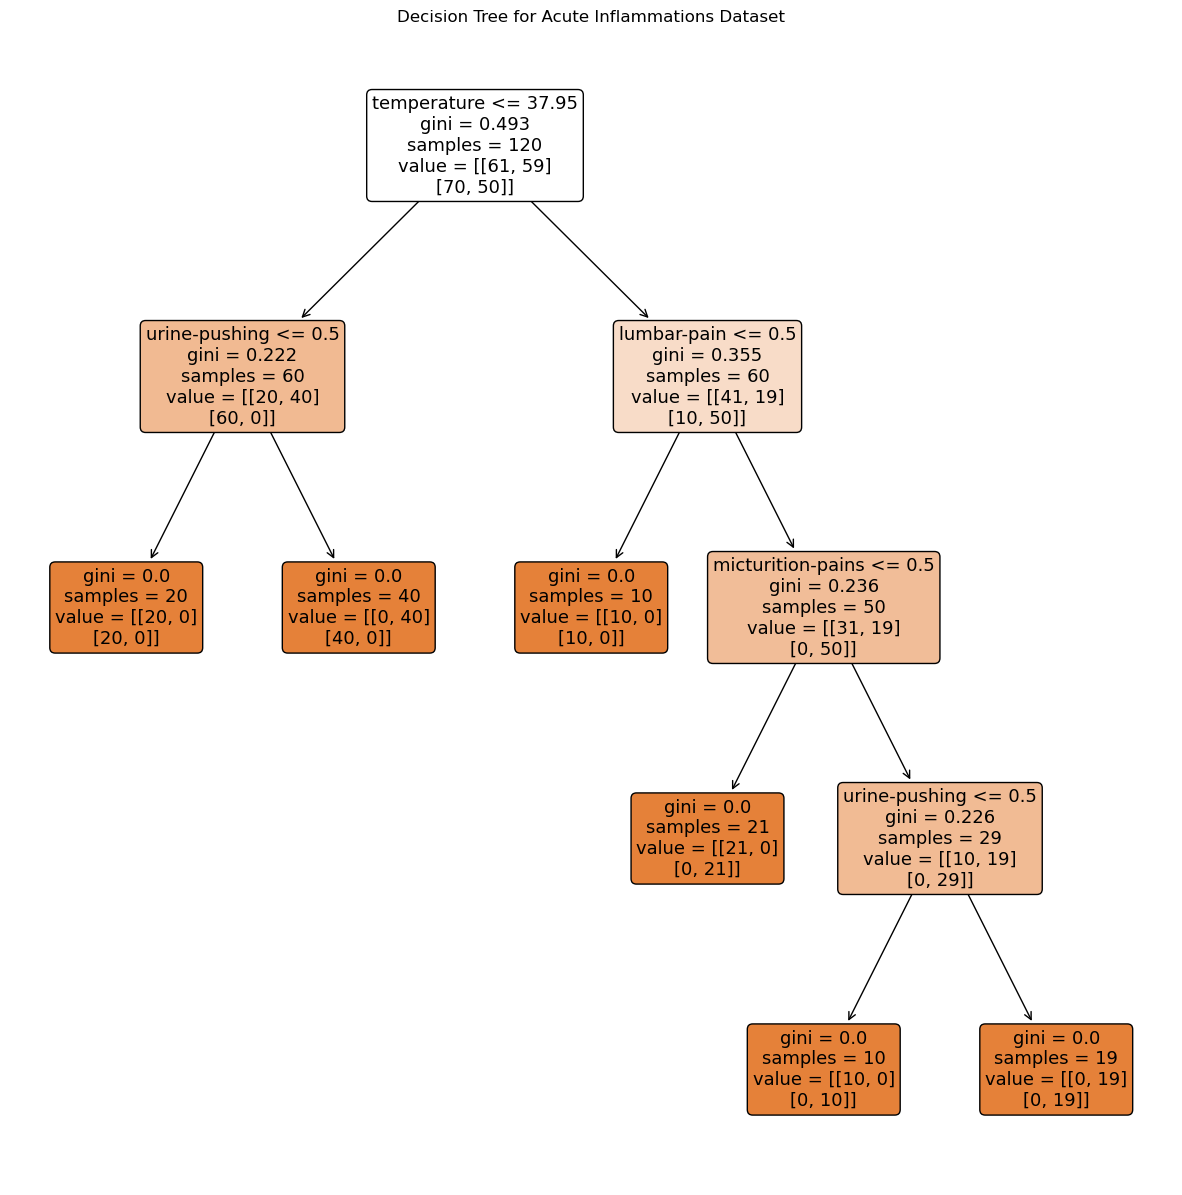

In [6]:
plt.figure(figsize=(15, 15))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree for Acute Inflammations Dataset")
plt.show()

In [7]:
def tree_to_rule(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_.feature
    ]
    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], conditions + [(name, "<=", threshold)])
            recurse(tree_.children_right[node], conditions + [(name, ">", threshold)])
        else:
            prediction = tree_.value[node][0].astype(int)
            rules.append({
                "conditions": conditions,
                "bladder-inflammation": prediction[0],
                "nephritis": prediction[1]
            })

    recurse(0, [])
    return rules
rules = tree_to_rule(tree, list(X.columns))
rules

[{'conditions': [('temperature', '<=', 37.95000076293945),
   ('urine-pushing', '<=', 0.5)],
  'bladder-inflammation': 20,
  'nephritis': 0},
 {'conditions': [('temperature', '<=', 37.95000076293945),
   ('urine-pushing', '>', 0.5)],
  'bladder-inflammation': 0,
  'nephritis': 40},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '<=', 0.5)],
  'bladder-inflammation': 10,
  'nephritis': 0},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '>', 0.5),
   ('micturition-pains', '<=', 0.5)],
  'bladder-inflammation': 21,
  'nephritis': 0},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '>', 0.5),
   ('micturition-pains', '>', 0.5),
   ('urine-pushing', '<=', 0.5)],
  'bladder-inflammation': 10,
  'nephritis': 0},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '>', 0.5),
   ('micturition-pains', '>', 0.5),
   ('urine-pushing', '>', 0.5)],
  'bladder-inflammation': 0,
  'nephrit

In [8]:
path = tree.cost_complexity_pruning_path(X, y)
alphas = path['ccp_alphas']
alphas

array([0.        , 0.04908333, 0.07947222, 0.11111111, 0.20423611])

In [9]:
clfs = []
alpha_scores = []

for alpha in alphas:
    tree = DecisionTreeClassifier(random_state=45, ccp_alpha=alpha)
    scores = cross_val_score(tree, X, y, cv=5)
    clfs.append(tree)
    alpha_scores.append(np.mean(scores))

best_alpha = alphas[np.argmax(alpha_scores)]
print("Best alpha for pruning:", best_alpha)

Best alpha for pruning: 0.0


In [10]:
pruned_tree = DecisionTreeClassifier(ccp_alpha = best_alpha, random_state=45)
pruned_tree.fit(X,y)

DecisionTreeClassifier(random_state=45)

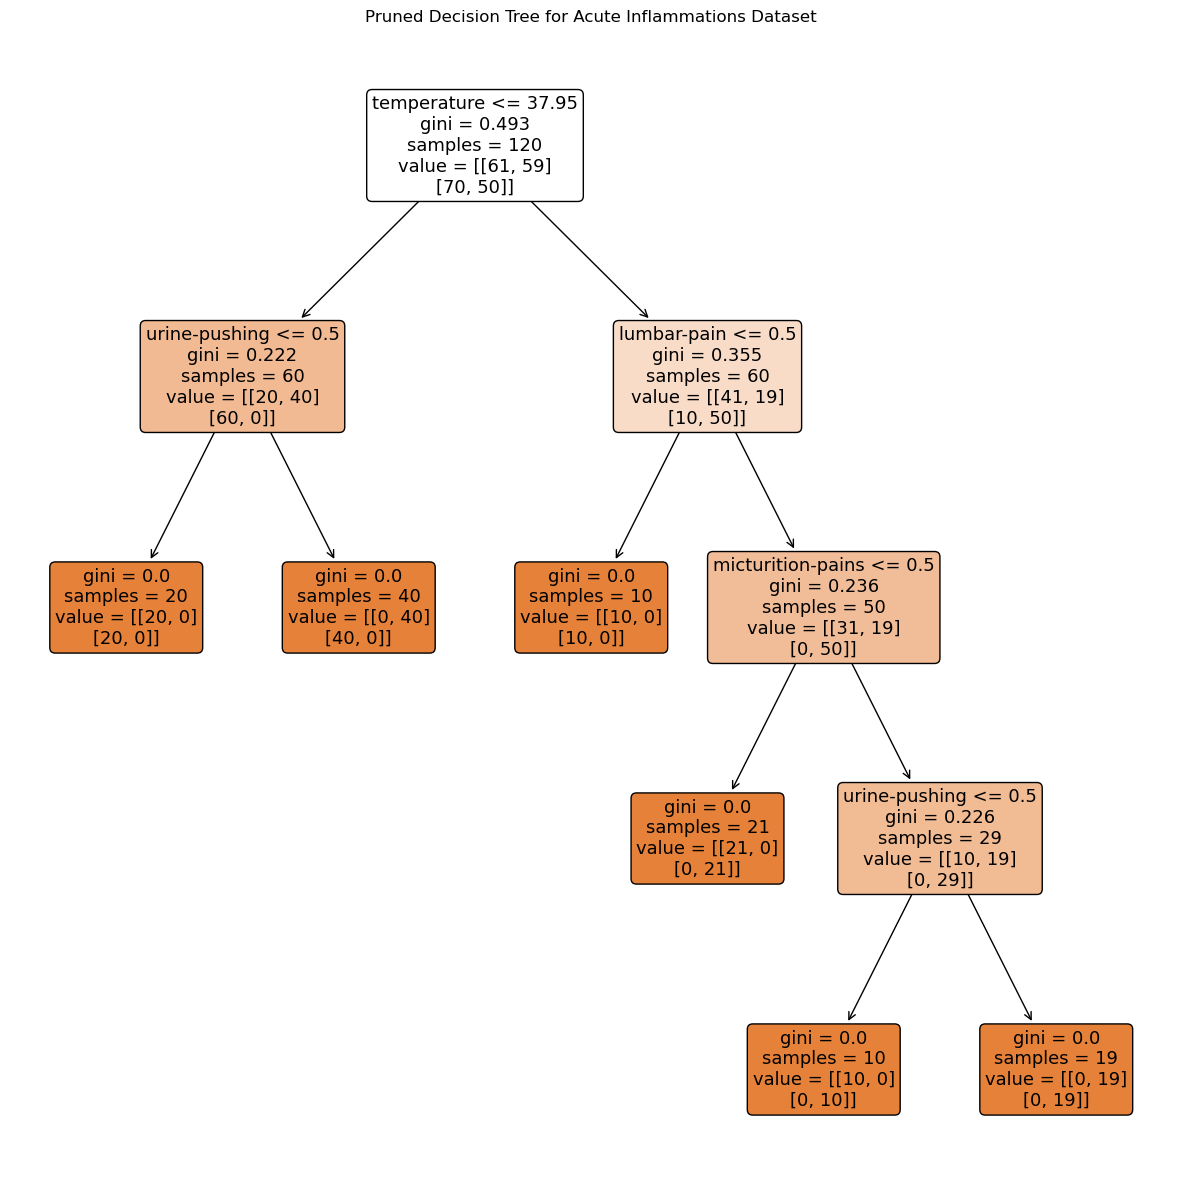

In [11]:
plt.figure(figsize=(15, 15))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title("Pruned Decision Tree for Acute Inflammations Dataset")
plt.show()

In [12]:
pruned_rules = tree_to_rule(pruned_tree, list(X.columns))
pruned_rules

[{'conditions': [('temperature', '<=', 37.95000076293945),
   ('urine-pushing', '<=', 0.5)],
  'bladder-inflammation': 20,
  'nephritis': 0},
 {'conditions': [('temperature', '<=', 37.95000076293945),
   ('urine-pushing', '>', 0.5)],
  'bladder-inflammation': 0,
  'nephritis': 40},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '<=', 0.5)],
  'bladder-inflammation': 10,
  'nephritis': 0},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '>', 0.5),
   ('micturition-pains', '<=', 0.5)],
  'bladder-inflammation': 21,
  'nephritis': 0},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '>', 0.5),
   ('micturition-pains', '>', 0.5),
   ('urine-pushing', '<=', 0.5)],
  'bladder-inflammation': 10,
  'nephritis': 0},
 {'conditions': [('temperature', '>', 37.95000076293945),
   ('lumbar-pain', '>', 0.5),
   ('micturition-pains', '>', 0.5),
   ('urine-pushing', '>', 0.5)],
  'bladder-inflammation': 0,
  'nephrit